# Lesson 5: 모델 학습

Deeplearning.AI & Upstage의 다음 강의를 듣고 정리한 노트북입니다.

https://learn.deeplearning.ai/courses/pretraining-llms/lesson/6/training-in-action

이 노트북에서는 pretrained LLM 사전 훈련을 진행합니다. 클라우드상에서 진행 시 반드시 비용이 얼마나 들지 미리 확인하세요!

__** M1 Mac 에서는 두 가지 문제 발생 **__
1. `torch.bfloat16` 학습 미지원 -> 미사용
2. `CustomDataset`, `CustomArguments`를 직접 선언하면 에러 발생 -> 별개 스크립트(util.py)로 분리 후 import하여 실행

In [1]:
# Ignore insignificant warnings (ex: deprecation warnings)
import warnings
warnings.filterwarnings('ignore')

# Set a seed value for reproducibility
import torch

def fix_torch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_torch_seed()

## 학습할 모델 로드

직전 레슨에서 저장한 업스케일 모델을 로드

In [2]:
from transformers import AutoModelForCausalLM

model_path = "data/TinySolar-308m-4k-init"
pretrained_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="cpu",
    # torch_dtype=torch.bfloat16, # M1 Mac 미지원
    use_cache=False
)

pretrained_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 1024)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=256, bias=False)
          (v_proj): Linear(in_features=1024, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (up_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (down_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Line

## 데이터셋 클래스 생성

이전 레슨에서 저장한 데이터를 불러오기 위한 torch Dataset을 생성합니다.

In [3]:
import datasets
from torch.utils.data import Dataset

### M1 Mac 에서는 아래와 같이 CustomDataset을 import 하면 에러가 발생함 -> 별개 스크립트에서 import
# class CustomDataset(Dataset):
#     def __init__(self, args, split="train"):
#         self.args = args
#         self.dataset = datasets.load_dataset(
#             "parquet",
#             data_files=args.dataset_name,
#             split=split
#         )

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         # token prediction을 위해 input_ids와 labels를 동일하게 설정
#         input_ids = torch.LongTensor(self.dataset[idx]["input_ids"])
#         labels = torch.LongTensor(self.dataset[idx]["input_ids"])

#         return {"input_ids":input_ids, "labels":labels}

from util import CustomDataset

## 훈련 환경 설정

`Trainer`의 인자로 넣을 `TrainArguments` 선언

In [4]:
from dataclasses import dataclass, field
import transformers

### M1 Mac 에서는 아래와 같이 CustomDataset을 import 하면 에러가 발생함 -> 별개 스크립트에서 import
# @dataclass
# class CustomArguments(transformers.TrainingArguments):
#     dataset_name: str = field(                           # Dataset configuration
#         default="./data/packaged_pretrain_dataset.parquet")
#     num_proc: int = field(default=1)                     # Number of subprocesses for data preprocessing
#     max_seq_length: int = field(default=32)              # Maximum sequence length

#     # Core training configurations
#     seed: int = field(default=0)                         # Random seed for initialization, ensuring reproducibility
#     optim: str = field(default="adamw_torch")            # Optimizer, here it's AdamW implemented in PyTorch
#     max_steps: int = field(default=30)                   # Number of maximum training steps
#     per_device_train_batch_size: int = field(default=2)  # Batch size per device during training

#     # Other training configurations
#     learning_rate: float = field(default=5e-5)           # Initial learning rate for the optimizer
#     weight_decay: float = field(default=0)               # Weight decay
#     warmup_steps: int = field(default=10)                # Number of steps for the learning rate warmup phase
#     lr_scheduler_type: str = field(default="linear")     # Type of learning rate scheduler
#     gradient_checkpointing: bool = field(default=True)   # Enable gradient checkpointing to save memory
#     dataloader_num_workers: int = field(default=2)       # Number of subprocesses for data loading
#     # bf16: bool = field(default=True)                     # Use bfloat16 precision for training on supported hardware
#     gradient_accumulation_steps: int = field(default=1)  # Number of steps to accumulate gradients before updating model weights
    
#     # Logging configuration
#     logging_steps: int = field(default=3)                # Frequency of logging training information
#     report_to: str = field(default="none")               # Destination for logging (e.g., WandB, TensorBoard)

#     # Saving configuration
#     # save_strategy: str = field(default="steps")          # Can be replaced with "epoch"
#     # save_steps: int = field(default=3)                   # Frequency of saving training checkpoint
#     # save_total_limit: int = field(default=2)             # The total number of checkpoints to be saved

from util import CustomArguments

체크포인트 저장 위치 선언

In [7]:
parser = transformers.HfArgumentParser(CustomArguments)
args, = parser.parse_args_into_dataclasses(
    args=["--output_dir", "output"]
)

In [8]:
print(args)

CustomArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=4,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataset_name=./data/packaged_pretrain_dataset.parquet,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=True,
gr

트레이닝 데이터셋 로드

In [9]:
train_dataset = CustomDataset(args=args)

In [10]:
print("Input shape: ", train_dataset[0]['input_ids'].shape)

Input shape:  torch.Size([64])


## 트레이너 실행 및 모니터링

먼저 loss를 기록하기 위한 콜백 함수 선언한 후, `Trainer` 오브젝트를 통해 훈련을 진행합니다.

In [11]:
from transformers import Trainer, TrainerCallback

# Define a custom callback to log the loss values
class LossLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.logs.append(logs)

    def __init__(self):
        self.logs = []

# Initialize the callback
loss_logging_callback = LossLoggingCallback()

In [12]:
from transformers import Trainer

trainer = Trainer(
    model=pretrained_model, 
    args=args, 
    train_dataset=train_dataset, 
    eval_dataset=None,
    callbacks=[loss_logging_callback] 
)

trainer.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

{'loss': 4.6969, 'learning_rate': 1.5e-05, 'epoch': 0.0}
{'loss': 4.1605, 'learning_rate': 3e-05, 'epoch': 0.0}
{'loss': 4.3244, 'learning_rate': 4.5e-05, 'epoch': 0.0}
{'loss': 4.6497, 'learning_rate': 4.9989989989989995e-05, 'epoch': 0.0}
{'loss': 4.0591, 'learning_rate': 4.9974974974974974e-05, 'epoch': 0.0}
{'loss': 3.9081, 'learning_rate': 4.995995995995996e-05, 'epoch': 0.0}
{'loss': 4.4868, 'learning_rate': 4.994494494494495e-05, 'epoch': 0.0}
{'loss': 4.4811, 'learning_rate': 4.992992992992993e-05, 'epoch': 0.0}
{'loss': 4.9954, 'learning_rate': 4.991491491491492e-05, 'epoch': 0.0}
{'loss': 4.3891, 'learning_rate': 4.98998998998999e-05, 'epoch': 0.0}
{'loss': 4.8871, 'learning_rate': 4.988488488488489e-05, 'epoch': 0.0}
{'loss': 4.7121, 'learning_rate': 4.9869869869869874e-05, 'epoch': 0.0}
{'loss': 4.307, 'learning_rate': 4.985485485485486e-05, 'epoch': 0.0}
{'loss': 4.6336, 'learning_rate': 4.983983983983984e-05, 'epoch': 0.0}
{'loss': 4.861, 'learning_rate': 4.98248248248248

TrainOutput(global_step=10000, training_loss=4.401318466949463, metrics={'train_runtime': 2258.1972, 'train_samples_per_second': 8.857, 'train_steps_per_second': 4.428, 'train_loss': 4.401318466949463, 'epoch': 0.26})

### loss 추이

In [27]:
loss_logging_callback.logs[-1]

{'train_runtime': 2258.1972,
 'train_samples_per_second': 8.857,
 'train_steps_per_second': 4.428,
 'train_loss': 4.401318466949463,
 'epoch': 0.26}

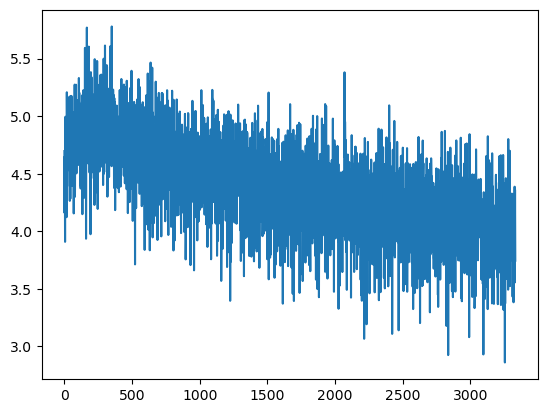

In [26]:
import matplotlib.pyplot as plt

plt.plot([log['loss'] for log in loss_logging_callback.logs[:-1]])

## 훈련 결과 확인

체크포인트로부터 모델을 불러와서 텍스트 생성을 테스트합니다..

In [29]:
from transformers import AutoTokenizer, TextStreamer
model_name_or_path = "upstage/TinySolar-248m-4k"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [30]:
prompt = "I am an engineer. I love"
inputs = tokenizer(prompt, return_tensors="pt").to(pretrained_model.device)

streamer = TextStreamer(
    tokenizer, 
    skip_prompt=True, 
    skip_special_tokens=True
)

outputs = pretrained_model.generate(
    **inputs, 
    streamer=streamer, 
    use_cache=True, 
    max_new_tokens=64,     
    do_sample=True,
    temperature=1.0,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


my music…so that I can write for that!! It's also a great sound but the audio isn't great though 30mm for me. But it only took 8 hours to use...the VIPI in Uruguay is so hard I can't do it much more!



어색하긴 하지만 그래도 처음에 비해선 훨씬 나아진 문장을 생성합니다.